 Пример кластеризации на реальных данных
В этом примере мы рассмотрим применение иерархической кластеризации к реальным данным. Согласно описанию, объекты — люди возраста 18 лет. Каждый объект обладает тремя атрибутами: Пол (Gender), Рост (Height) и Вес (Weight). Для начала подключим необходимые библиотеки.

In [31]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing

Импортируем датасет в датафрейм и проверим, все ли корректно импортировалось.

<b>Примечание:</b> Изначально рост был указан в дюймах, а вес -- в фунтах. Для удобства восприятия значения были переведены в сантиметры и килограммы, соответственно.

In [37]:
df = pd.read_csv("height-weight_metric.csv", sep=";", decimal='.', index_col='id')
df.head()

,Gender,Height,Weight
id,,,
1,Male,187.571423,109.720985
2,Male,174.706036,73.622732
3,Male,188.239668,96.497550
4,Male,182.196685,99.809504
5,Male,177.499761,93.598619


Поскольку каждый объект имеет всего три признака, вполне возможно построить график в 3d. Для этого сначала сделаем признак <code>Gender</code> числовым (женщинам поставим в соответствие 0, мужчинам — 1).

C:\Users\makar\AppData\Local\Temp\ipykernel_30024\950073717.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].replace('Female', 0, inplace = True)
C:\Users\makar\AppData\Local\Temp\ipykernel_30024\950073717.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

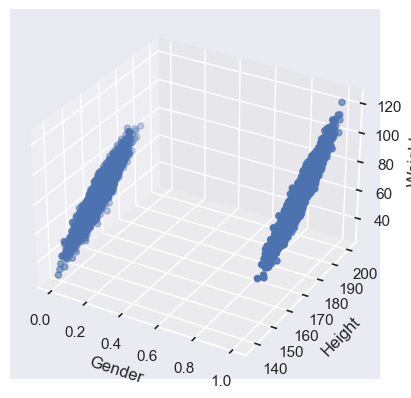

In [33]:
### 3d построение
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")
df['Gender'].replace('Female', 0, inplace = True)
df['Gender'].replace('Male', 1, inplace = True)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df['Gender']
y = df['Height']
z = df['Weight']

ax.set_xlabel("Gender")
ax.set_ylabel("Height")
ax.set_zlabel("Weight")
ax.scatter(x, y, z)
plt.show()

Нетрудно заметить, что объекты явно можно разделить на 2 кластера по половому признаку. Это было очевидно с самого начала, поэтому попробуем на пол пока что внимания не обращать (исключим его из предикторов).

<Axes: xlabel='Height', ylabel='Weight'>

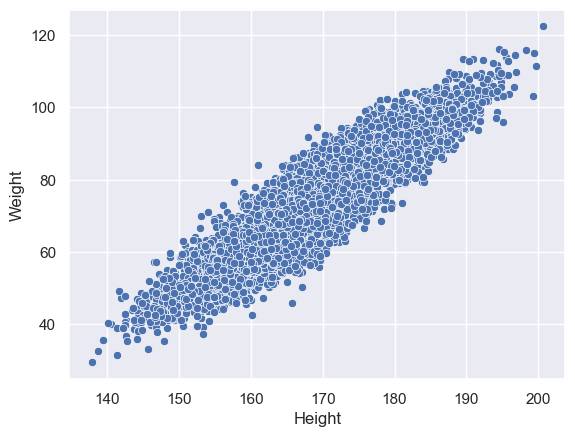

In [34]:
df_no_gender = df.drop(columns = 'Gender')
sns.scatterplot(data = df_no_gender, x = "Height", y = "Weight")

Выбросов не видно. Данные имеют разные единицы измерения, стандартизуем их. Используем линейную нормировку (MinMaxScaler).

<Axes: xlabel='Height', ylabel='Weight'>

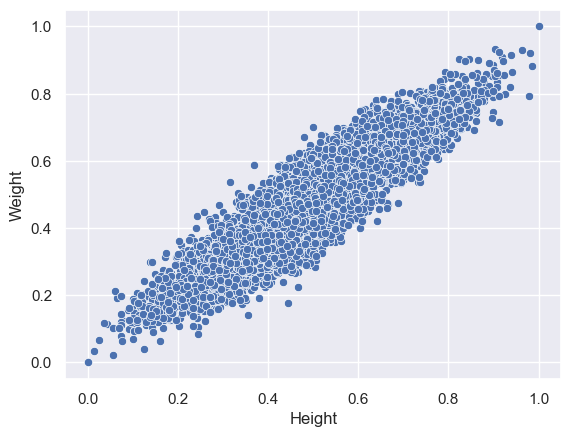

In [35]:
stand = preprocessing.MinMaxScaler()
X = stand.fit_transform(df_no_gender)
X = pd.DataFrame(X, index = df_no_gender.index, columns = df_no_gender.columns)
sns.scatterplot(data = X, x = "Height", y = "Weight")

Теперь нужно определиться с количеством кластеров. Построим график каменистой осыпи.

In [38]:
# Произведем иерархическую кластеризацию. Для определения расстояния между кластерами будем использовать метод Варда.
# Построим график каменистой осыпи для определения числа кластеров.
link = linkage(X, 'ward', 'euclidean')
dist = link[:, 2][::-1]
idxs = range(1, len(dist) + 1)

Text(0.5, 1.0, 'График каменистой осыпи')

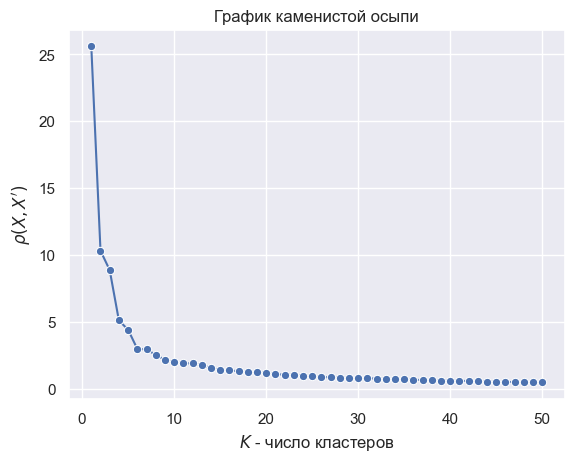

In [39]:
#Рассмотрим случаи до 50 кластеров


rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = idxs[:50]
rock_line[r'$\rho(X, X^\prime)$'] = dist[:50]
sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$\rho(X, X^\prime)$", markers = True, marker = 'o').set_title('График каменистой осыпи')

Рассмотрим более детально случаи до 10 кластеров.


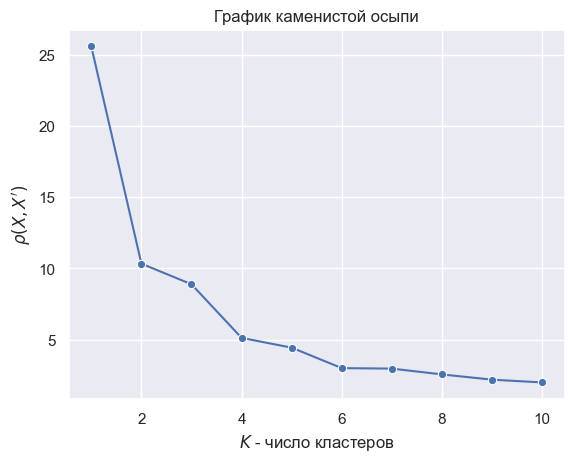

In [14]:
rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = idxs[:10]
rock_line[r'$\rho(X, X^\prime)$'] = dist[:10]
lnplt = sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$\rho(X, X^\prime)$", markers = True, marker = 'o').set_title('График каменистой осыпи')
lnplt = lnplt.get_figure()
lnplt.savefig('elbow_hie.png', dpi=400)

Можно заметить, что график начинает быть более пологим, начиная с отметки в шесть кластеров. Также неплохие кандидаты — четыре и два. Поскольку два — слишком очевидный вариант, рассмотрим случаи шести и четырех кластеров.


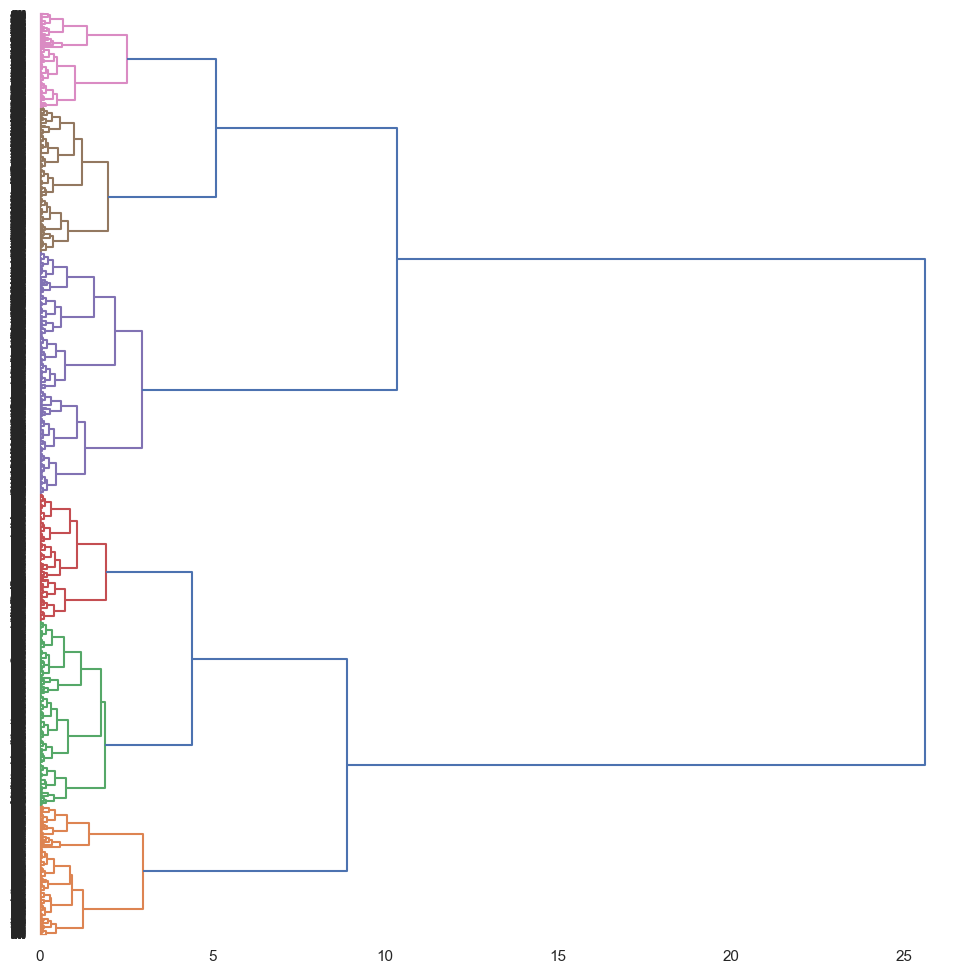

In [15]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#Построение дендрограммы занимает некоторое время. Стоит набраться терпения.

fig_1 = plt.figure(figsize=(12,12))
dn = dendrogram(link,
                color_threshold=dist[4],
                orientation = "right",
                leaf_rotation=0.)

In [16]:
#Добавим в данные графу "кластер" и посмотрим
df_no_gender['Сluster'] = fcluster(link, 6, criterion='maxclust')
df_no_gender['Сluster'] = df_no_gender['Сluster'] - 1
df_no_gender.head()
df_no_gender.groupby('Сluster').mean()

,Height,Weight
Сluster,,
0,153.726601,51.939417
1,161.261188,61.045558
2,165.848409,68.679589
3,171.606581,78.330033
4,177.907996,88.081768
5,184.949463,96.708501


Что же у нас получилось?


*   0 — 154 см, 52 кг — достаточно миниатюрные женщины (возможно совсем мизерное количество невыских мужчин);
*   1 — 161 см, 61 кг — скорее всего преимущественно женщины, однако может быть и какой-то небольшой процент мужчин;
*   2 — 166 см, 69 кг — большинство -- женщины среднего размера, но скорее всего и существенный процент мужчин;
*   3 — 172 см, 78 кг — большинство -- мужчины среднего размера, но скорее всего и существенный процент женщин;
*   4 — 178 см, 88 кг — мужчины среднего или чуть больше, чем среднего размера (допустимо некоторое, но незначительное, количество крупных женщин);
*   5 — 185 см, 97 кг — крупные мужчины, возможны отдельные представители очень крупных женщин.
Построим график.

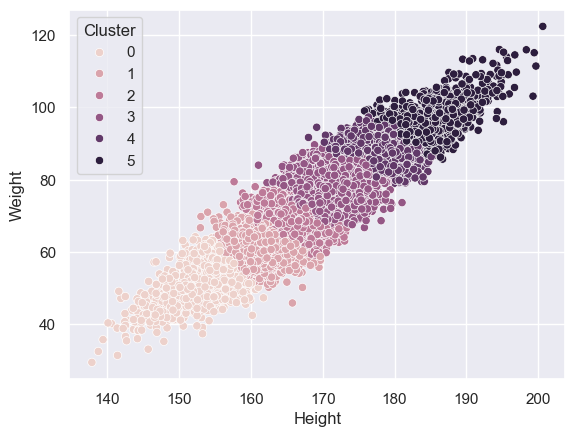

In [17]:
sns.scatterplot(data = df_no_gender, x = "Height", y = "Weight", hue = 'Сluster')
df_comp = df_no_gender.copy(deep=True)

Проверим наши предположения, а именно включим признак "Пол"

In [18]:
df['Cluster'] = df_no_gender['Сluster']
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,0.013437,153.726601,51.939417
1,0.061031,161.261188,61.045558
2,0.276766,165.848409,68.679589
3,0.733714,171.606581,78.330033
4,0.977607,177.907996,88.081768
5,0.999025,184.949463,96.708501


Мы оказались правы, действительно, кластер 0 состоит почти на 99% из женщин. В кластере 1 уже порядка 6% мужчин. Кластеры 2 и 3 имеют пропорцию примерно 27:73 для мужчин и женщин соответственно. В кластерах 4 и 5 большинство -- мужчины.

Рассмотрим случай четырех кластеров.

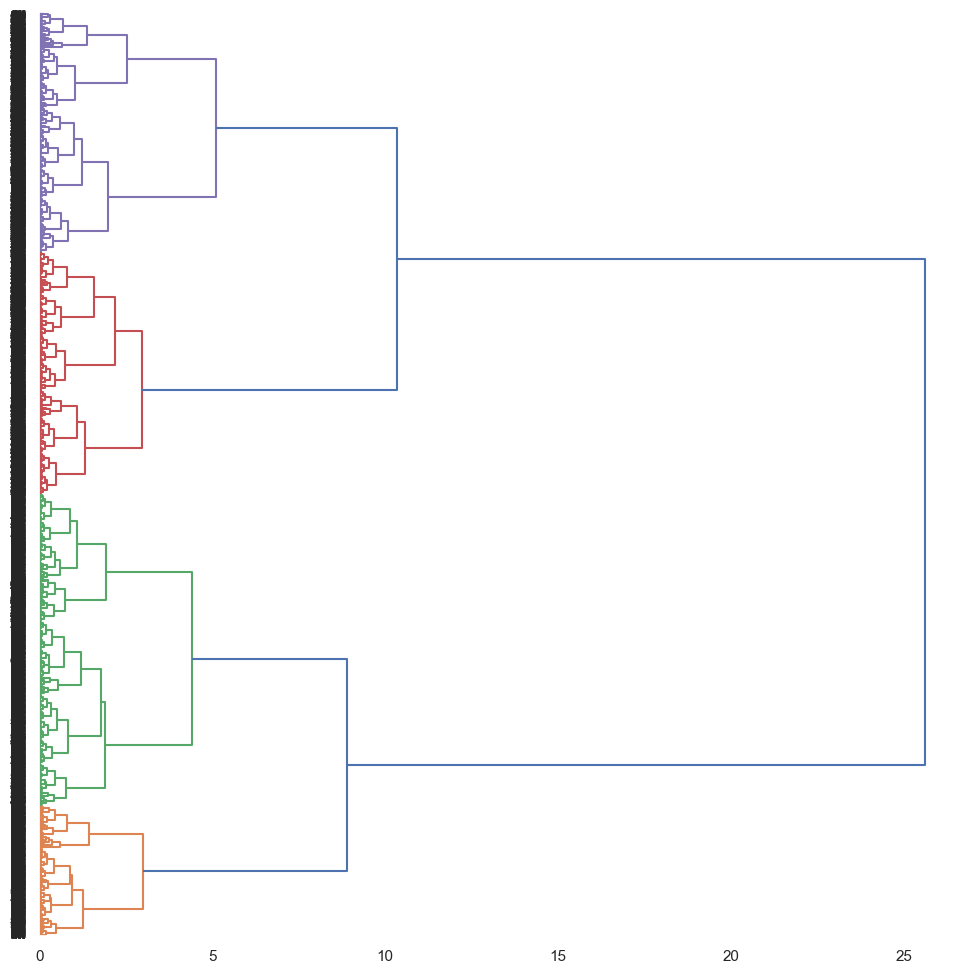

In [19]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

fig_1 = plt.figure(figsize=(12,12))
dn = dendrogram(link,
                color_threshold=dist[2],
                orientation = "right",
                leaf_rotation=0.)

In [20]:
df_no_gender['Сluster'] = fcluster(link, 4, criterion='maxclust')
df_no_gender['Сluster'] = df_no_gender['Сluster'] - 1
df_no_gender.groupby('Сluster').mean()

,Height,Weight
Сluster,,
0,153.726601,51.939417
1,163.128998,64.153958
2,171.606581,78.330033
3,180.698473,91.500473


<Axes: title={'center': '4 кластера'}, xlabel='Height', ylabel='Weight'>

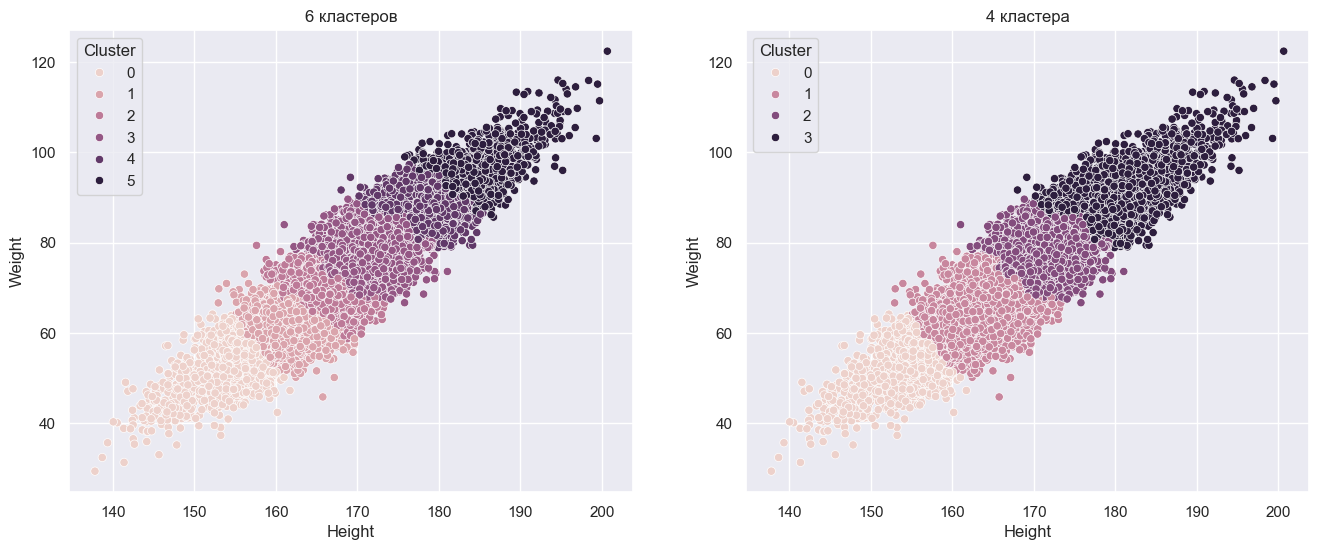

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.set_title('6 кластеров')
sns.scatterplot(data=df_comp, x="Height", y="Weight", hue = 'Сluster', ax=ax1)

ax2.set_title('4 кластера')
sns.scatterplot(data=df_no_gender, x="Height", y="Weight", hue = 'Сluster', ax=ax2)

В таком случае, без изменений остались бывшие кластеры 0 и 3. При этом произошло объединение бывших кластеров 1,2 и 4,5. Тогда имеем:

*   0 — миниатюрные люди;
*   1 — люди чуть меньше среднего;
*   2 — люди чуть крупнее среднего;
*   3 — крупные люди.

In [22]:
df['Cluster'] = df_no_gender['Сluster']
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,0.013437,153.726601,51.939417
1,0.148873,163.128998,64.153958
2,0.733714,171.606581,78.330033
3,0.986095,180.698473,91.500473


Добавим в процесс кластеризации пол. Поскольку пол обозначается числами 0 или 1, то в результате линейной нормировки эти значения сохранятся, поэтому просто добавим к нашему нормированному набору данных X столбец <code>Gender</code>.

In [23]:
X['Gender'] = df['Gender']
X.head()

,Height,Weight,Gender
id,,,
1,0.791728,0.863139,1
2,0.586958,0.475476,1
3,0.802364,0.721131,1
4,0.706182,0.756699,1
5,0.631424,0.689999,1


Проведем аналогичные процедуры, что и в предыдущем случае.

Text(0.5, 1.0, 'График каменистой осыпи')

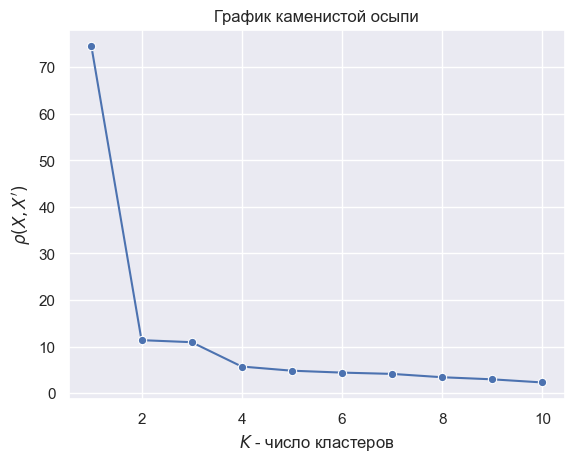

In [24]:
link = linkage(X, 'ward', 'euclidean')
dist = link[:, 2][::-1]
idxs = range(1, len(dist) + 1)


rock_line = pd.DataFrame()
rock_line[r'$K$ - число кластеров'] = idxs[:10]
rock_line[r'$\rho(X, X^\prime)$'] = dist[:10]
sns.lineplot(data = rock_line, x = r"$K$ - число кластеров", y = r"$\rho(X, X^\prime)$", markers = True, marker = 'o').set_title('График каменистой осыпи')

Очевидно разделение на два кластера, хотя можно заподозрить и четыре. Начнем с двух

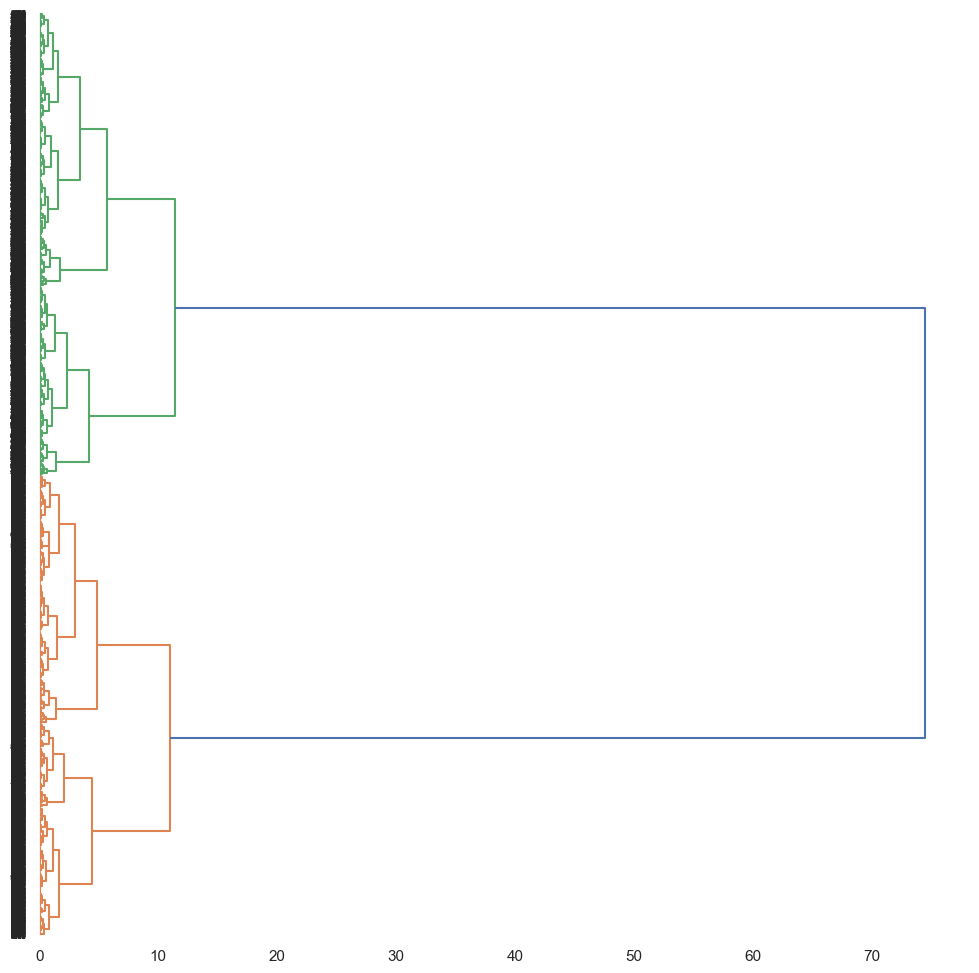

In [25]:
fig_1 = plt.figure(figsize=(12,12))
dn = dendrogram(link,
                color_threshold=dist[0],
                orientation = "right",
                leaf_rotation=0.)

In [30]:
df['Cluster'] = fcluster(link, 2, criterion='maxclust')
df['Cluster'] = df['Cluster'] - 1
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,0.0,161.820285,61.625051
1,1.0,175.326919,84.831057


Четкое разделение на женщин и мужчин.
А если все же четыре?

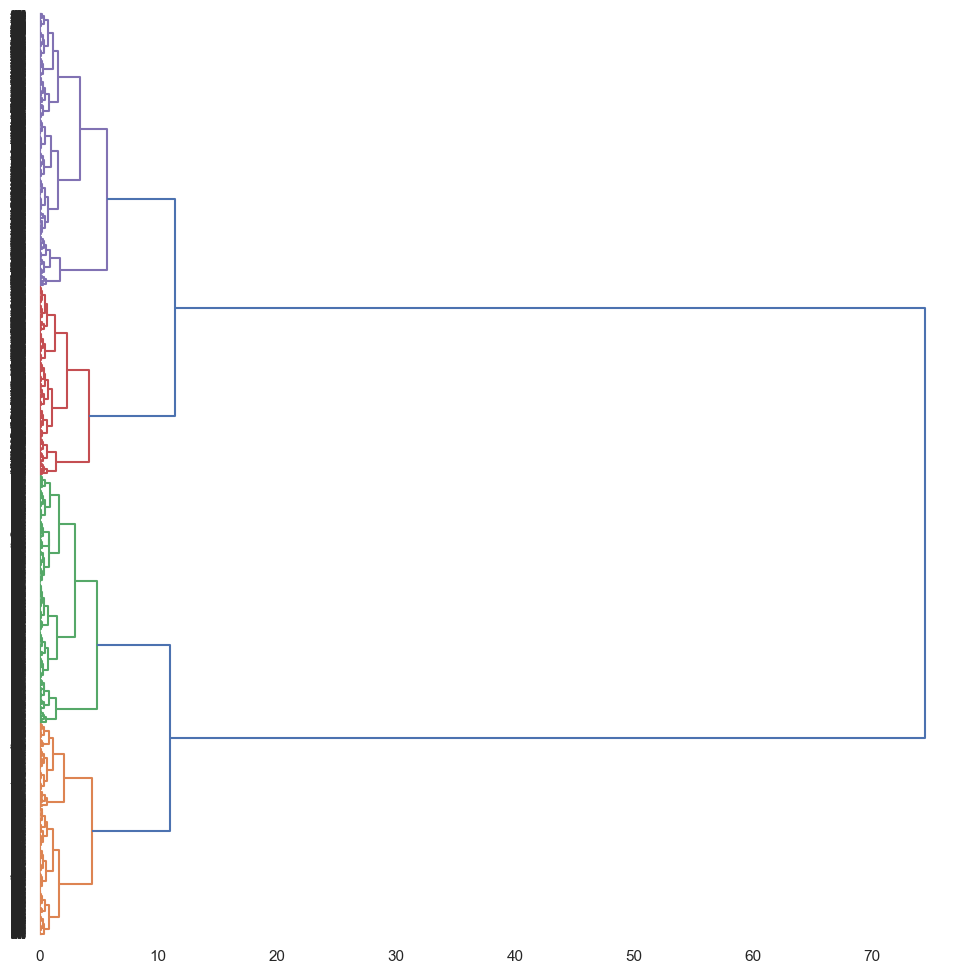

In [27]:
fig_1 = plt.figure(figsize=(12,12))
dn = dendrogram(link,
                # повернуть подписи вертикально
                color_threshold=dist[2],
                orientation = "right",
                leaf_rotation=0.)

In [28]:
df['Cluster'] = fcluster(link, 4, criterion='maxclust')
df['Cluster'] = df['Cluster'] - 1
df.groupby('Cluster').mean()

,Gender,Height,Weight
Cluster,,,
0,0.0,167.545196,68.643539
1,0.0,156.900140,55.593172
2,1.0,182.149616,92.625291
3,1.0,170.613097,79.445998


Мужчины и женщины разбились на два подмножества соответственно: крупнее и миниатюрнее.

Визуализируем кластеризацию на 4 кластера с учетом пола.

<Axes: xlabel='Height', ylabel='Weight'>

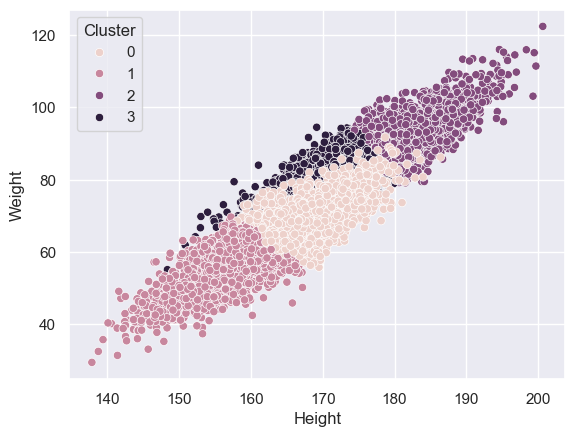

In [29]:
sns.scatterplot(data=df, x="Height", y="Weight", hue = 'Cluster')